In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0],
    True
)

Load the data.

In [2]:
df = pd.read_csv('jena_daily_temperatures.csv', parse_dates=['Date Time'], dayfirst=True, index_col='Date Time')
temperature = np.array(df['temperature'])

Standardize the data to work with neural networks more efficiently.

In [3]:
temperature_mean = temperature.mean()
temperature_std = temperature.std()
temperature_normed = (temperature - temperature_mean) / temperature_std

In [4]:
def prepare_inputs_and_targets(ts, len_in, len_out):
    num_seqs = len(ts) - len_in - len_out
    seqs_in = [ts[i:i+len_in] for i in range(num_seqs)]
    seqs_out = [ts[len_in+i:len_in+i+len_out] for i in range(num_seqs)]
    return np.stack(seqs_in), np.stack(seqs_out)

We will use 1/5 of the series as input and predict 1/5 of the series.

In [5]:
seq_len_in = len(temperature) // 5
seq_len_out = len(temperature) // 5
seqs_in, seqs_out = prepare_inputs_and_targets(temperature_normed, seq_len_in, seq_len_out)

Prepare the neural network.

In [8]:
inputs = keras.layers.Input(shape=(seq_len_in, 1))
lstm_out = keras.layers.LSTM(16)(inputs)
outputs = keras.layers.Dense(seq_len_out)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 584, 1)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 584)               9928      
Total params: 11,080
Trainable params: 11,080
Non-trainable params: 0
_________________________________________________________________


Train the network.

In [9]:
history = model.fit(
    seqs_in.reshape(-1, seq_len_in, 1),
    seqs_out,
    epochs=50,
)

Epoch 1/50
55/55 [==============================] - 8s 115ms/step - loss: 0.8921
Epoch 2/50
55/55 [==============================] - 6s 113ms/step - loss: 0.6708
Epoch 3/50
55/55 [==============================] - 6s 113ms/step - loss: 0.6067
Epoch 4/50
55/55 [==============================] - 6s 113ms/step - loss: 0.4764
Epoch 5/50
55/55 [==============================] - 6s 116ms/step - loss: 0.3348
Epoch 6/50
55/55 [==============================] - 6s 113ms/step - loss: 0.2925
Epoch 7/50
55/55 [==============================] - 6s 113ms/step - loss: 0.2764
Epoch 8/50
55/55 [==============================] - 6s 114ms/step - loss: 0.2692
Epoch 9/50
55/55 [==============================] - 6s 113ms/step - loss: 0.2694
Epoch 10/50
55/55 [==============================] - 6s 113ms/step - loss: 0.2677
Epoch 11/50
55/55 [==============================] - 6s 113ms/step - loss: 0.2668
Epoch 12/50
55/55 [==============================] - 6s 113ms/step - loss: 0.2613
Epoch 13/50
55/55 [======

Test the network and evaluate the forecast against the actual future.

MAPE: 0.4369251521932528


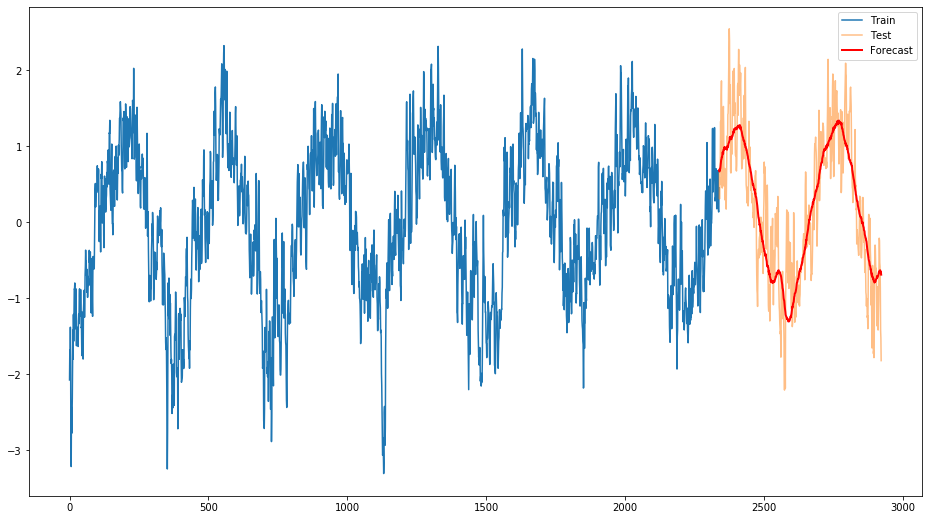

In [10]:
true_past = temperature_normed[:-seq_len_out]
true_future = temperature_normed[-seq_len_out:]
seq_in = temperature_normed[-(seq_len_out+seq_len_in):-seq_len_out]
forecast = model.predict(seq_in.reshape(1, -1, 1))[-1]

mape = np.median(np.abs((true_future - forecast)/true_future))
print(f'MAPE: {mape}')

x = np.arange(len(forecast)) + len(true_past)

plt.figure(figsize=(16,9))
plt.plot(true_past, label='Train')
plt.plot(x, true_future, label='Test', alpha=0.5)
plt.plot(x, forecast, label='Forecast', color='red', linewidth=2)
plt.legend()